In [331]:
import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from statistics import mean

# Gradient descent with momentum

In [332]:
def plot_fourth_order(w, optimizer, std=0, color='r', paramlabel='parameter values', objfun=True):
    W = torch.arange(-4, 6, 0.1)
    LOSS = []
    for w.state_dict()['linear.weight'][0] in W:
        LOSS.append(fourth_order(w(torch.tensor([[1.0]]))).item())
    w.state_dict()['linear.weight'][0] = 6
    n_epochs = 100
    parameter = []
    loss_list = []

    #n_epochs
    for n in range(n_epochs):
        optimizer.zero_grad()
        loss = fourth_order(w(torch.tensor([[1.0]]))) + std * torch.randn(1, 1)
        loss_list.append(loss)
        parameter.append(w.state_dict()['linear.weight'][0].detach().data.item())
        loss.backward()
        optimizer.step()
    
    # Plotting
    if objfun:
        plt.plot(W.numpy(), LOSS, label='objective function')
    plt.plot(parameter, loss_list, 'ro',label=paramlabel, color=color)
    plt.xlabel('w')
    plt.ylabel('l(w)')
    plt.legend()

In [333]:
class one_param(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(one_param, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=False)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [334]:
w = one_param(1, 1)

In [335]:
def fourth_order(yhat): 
    out = torch.mean(2 * (yhat ** 4) - 9 * (yhat ** 3) - 21 * (yhat ** 2) + 88 * yhat + 48)
    return out

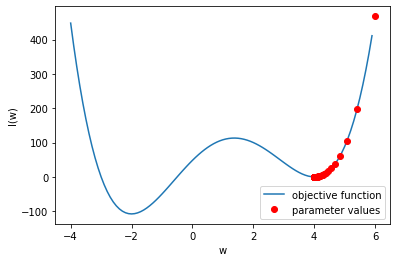

In [336]:
optimizer_nomomentum = torch.optim.SGD(w.parameters(), lr=0.001)
plot_fourth_order(w, optimizer_nomomentum)

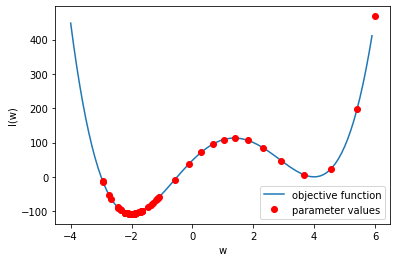

In [337]:
optimizer_momentum = torch.optim.SGD(w.parameters(), lr=0.001, momentum = 0.9)
plot_fourth_order(w, optimizer_momentum)

### Adding momentum is like rolling a ball down a hill while taking into account its momentum. The ball's momentum causes it to not settle into a local minimum, rather move to the global minimum.

# Initializing weights

In [338]:
class Net(nn.Module):

    def __init__(self, insize, outsize, init_method):
        super(Net, self).__init__()
        self.linear = nn.Linear(insize, 10)
        
        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.linear.weight)
        elif init_method == 'uniform':
            self.linear.weight.data.uniform_(0, 1)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.linear.weight, nonlinearity = 'tanh')

        self.linear2 = nn.Linear(10, outsize)

    def forward(self,x):
        yhat = torch.tanh(self.linear(x))
        yhat = self.linear2(yhat)
        return yhat

In [339]:
xvals, yvals = make_regression(n_features = 2, n_samples = 300)
xvals, yvals = torch.from_numpy(xvals.astype(np.float32)), torch.from_numpy(yvals.astype(np.float32))

In [340]:
class data(Dataset):

    def __init__(self, xvals, yvals):
        self.x = xvals
        self.y = yvals
        self.len = xvals.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [341]:
dataset = data(xvals, yvals)
loader = DataLoader(dataset = dataset, batch_size = 5, shuffle = True)

In [342]:
def train_model(model, lr, epochs, data):
    criterion = nn.MSELoss()
    opt = optim.SGD(model.parameters(), lr = lr)
    mean_loss_list = []

    for epoch in range(epochs):
        loss_list = []
        if epoch % (epochs/5) == 0 : 
            print(f'Epoch : {epoch + 1}')
        
        for x,y in data :
            opt.zero_grad()
            yhat = model.forward(x)

            loss = criterion(yhat,y)
            loss_list.append(loss.item())

            loss.backward()
            opt.step()
        
        mean_loss = mean(loss_list)
        if epoch % (epochs/5) == 0 : 
            print('Mean loss : ', mean_loss)
            print('-' * 50)
        mean_loss_list.append(mean_loss) 

    return mean_loss_list
        

In [343]:
xavier_model = Net(2,1, 'xavier')
uniform_model = Net(2,1, 'uniform')
default_model = Net(2,1, None)
he_model = Net(2,1, 'he')
epochs = 50
lr = 0.00001

In [344]:
xavier_loss = train_model(xavier_model, lr, epochs, loader)

Epoch : 1
Mean loss :  2780.801020558675
--------------------------------------------------
Epoch : 11
Mean loss :  2777.8814427693683
--------------------------------------------------
Epoch : 21
Mean loss :  2776.6798919677735
--------------------------------------------------
Epoch : 31
Mean loss :  2774.7288965861003
--------------------------------------------------
Epoch : 41
Mean loss :  2772.57806447347
--------------------------------------------------


In [345]:
uniform_loss = train_model(uniform_model, lr, epochs, loader)

Epoch : 1
Mean loss :  2793.8507486979165
--------------------------------------------------
Epoch : 11
Mean loss :  2791.3163073221845
--------------------------------------------------
Epoch : 21
Mean loss :  2783.4018379211425
--------------------------------------------------
Epoch : 31
Mean loss :  2779.0327880859377
--------------------------------------------------
Epoch : 41
Mean loss :  2774.3392659505207
--------------------------------------------------


In [346]:
default_loss = train_model(default_model, lr, epochs, loader)

Epoch : 1
Mean loss :  2777.4127655029297
--------------------------------------------------
Epoch : 11
Mean loss :  2773.628852335612
--------------------------------------------------
Epoch : 21
Mean loss :  2773.6373814900717
--------------------------------------------------
Epoch : 31
Mean loss :  2765.15555750529
--------------------------------------------------
Epoch : 41
Mean loss :  2764.080510965983
--------------------------------------------------


In [347]:
he_loss = train_model(he_model, lr, epochs, loader)

Epoch : 1
Mean loss :  2779.8771967569987
--------------------------------------------------
Epoch : 11
Mean loss :  2772.017549641927
--------------------------------------------------
Epoch : 21
Mean loss :  2764.842744954427
--------------------------------------------------
Epoch : 31
Mean loss :  2757.93129603068
--------------------------------------------------
Epoch : 41
Mean loss :  2754.221636454264
--------------------------------------------------


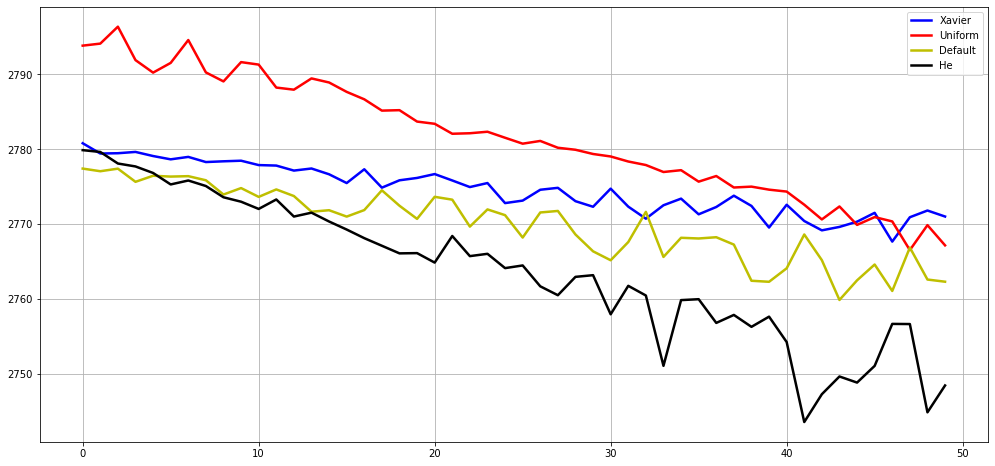

In [348]:
plt.figure(figsize = (17,8))
plt.plot(xavier_loss, label = 'Xavier', c='b', linewidth = 2.5)
plt.plot(uniform_loss, label = 'Uniform', c='r', linewidth = 2.5)
plt.plot(default_loss, label = 'Default', c='y', linewidth = 2.5)
plt.plot(he_loss, label = 'He', c='black', linewidth = 2.5)
plt.grid(True)
plt.legend()
plt.show()

### Different init methods allow for faster training depending on other characteristics, such as activation functions. In this case, using tanh with the He init menthod seems to work best

# Batch normalization

In [381]:
class BatchNormModel(nn.Module):

    def __init__(self, insize, outsize, batchnorm):
        super(BatchNormModel, self).__init__()
        self.batchnorm = batchnorm
        
        self.linear1 = nn.Linear(insize, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, outsize)

        self.bn1 = nn.BatchNorm1d(100)
        self.bn2 = nn.BatchNorm1d(100)

    def forward(self,x):

        if self.batchnorm : 
            out = self.bn1(torch.sigmoid(self.linear1(x)))
            out = self.bn2(torch.sigmoid(self.linear2(out)))
            out = self.linear3(out)
        else :
            out = torch.relu(self.linear1(x))
            out = torch.relu(self.linear2(out))
            out = self.linear3(out)

        return out

In [382]:
bnorm_model = BatchNormModel(2,1,True)
nobnorm_model = BatchNormModel(2,1,False)
epochs2 = 200
lr2 = 0.001

In [383]:
bnorm_loss = train_model(bnorm_model, lr2, epochs2, loader)

Epoch : 1
Mean loss :  2781.030664571126
--------------------------------------------------
Epoch : 41
Mean loss :  2779.1917078653973
--------------------------------------------------
Epoch : 81
Mean loss :  2779.308308919271
--------------------------------------------------
Epoch : 121
Mean loss :  2779.336433919271
--------------------------------------------------
Epoch : 161
Mean loss :  2779.050589752197
--------------------------------------------------


In [384]:
nobnorm_loss = train_model(nobnorm_model, lr2, epochs2, loader)

Epoch : 1
Mean loss :  2773.5531374613442
--------------------------------------------------
Epoch : 41
Mean loss :  2686.1088742574057
--------------------------------------------------
Epoch : 81
Mean loss :  2699.4283986409505
--------------------------------------------------
Epoch : 121
Mean loss :  2654.133819071452
--------------------------------------------------
Epoch : 161
Mean loss :  2680.072257486979
--------------------------------------------------


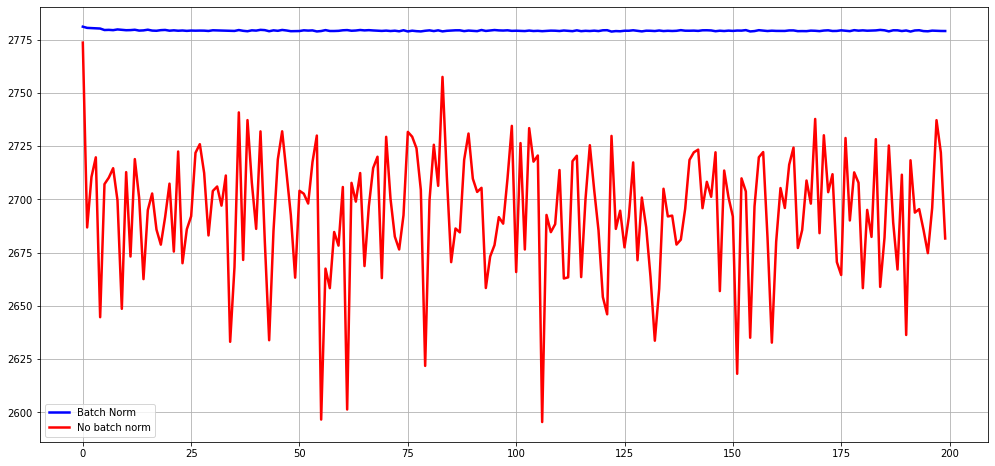

In [385]:
plt.figure(figsize = (17,8))
plt.plot(bnorm_loss, label = 'Batch Norm', c='b', linewidth = 2.5)
plt.plot(nobnorm_loss, label = 'No batch norm', c='r', linewidth = 2.5)
plt.grid(True)
plt.legend()
plt.show()